In [170]:
from collections import defaultdict, Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib


In [246]:
#chroms = [str(x) for x in range(1, 23)] #+ ['X']
#chroms = ['X']
chroms = ['22']

family_sizes = [4]
phase_dir = '../phased_test_ssc'
#phase_dir = '../phased_test_with_missing'
#data_dir = '../split_gen_ihart'

#family_sizes = [3, 4, 5, 6]
#phase_dir = '../phased_ihart_miss'
#data_dir = '../split_gen_miss'

#family_sizes = [4]
#phase_dir = '../phased_ihart_quad'
#data_dir = '../split_gen_miss'

#family_sizes = [3, 4]
#phase_dir = '../phased_ssc_miss'
#data_dir = '../split_gen_miss_ssc'

In [247]:
ped_files = ['../data/160826.ped', '../data/ssc.ped', '../data/160826.ped.quads.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

# Filter Families

In [248]:
monozygotic_multiple_families = set()
with open('../data/160826.iHART.db.query.csv', 'r') as f:
    next(f)
    for line in f:
        pieces = line.split(',')
        if 'MZ' in pieces[11]:
            monozygotic_multiple_families.add(pieces[3])
print('Mono multiples', len(monozygotic_multiple_families))

Mono multiples 96


In [249]:
family_to_chroms = defaultdict(set)
family_to_individuals = dict()
for chrom in chroms:
    print(chrom, end=' ')

    for j in family_sizes:
        try:
            with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r') as f:
                next(f) # skip header
                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    family_to_chroms[family_key].add(chrom)
                    family_to_individuals[family_key] = pieces[1:(1+j)]
        except FileNotFoundError:
            print('File not found', 'chrom', chrom, 'family size', j)
        except StopIteration:
            print('File empty', 'chrom', chrom, 'family size', j)
            
families_with_all_chroms = set([k for k, v in family_to_chroms.items() if len(v)==len(chroms)])
print('Families with all chroms', len(families_with_all_chroms))
print(Counter([len(v) for v in family_to_chroms.values()]))


22 Families with all chroms 516
Counter({1: 516})


In [250]:
families_with_lcl = set([x for x, inds in family_to_individuals.items() if len([y for y in inds if 'LCL' in y]) > 0])
print('Families with LCL', len(families_with_lcl))

families_to_include = [x for x in families_with_all_chroms if x.split('.')[0] not in monozygotic_multiple_families and x not in families_with_lcl]
print('Final families', len(families_to_include))

Families with LCL 0
Final families 516


# Read in deletions

In [251]:
from collections import namedtuple
Deletion = namedtuple('Deletion', ['family', 'chrom', 
                                   'start_pos', 'end_pos', 'length',
                                   'opt_start_pos', 'opt_end_pos', 'opt_length',
                                   'trans', 'notrans',
                                   'is_mat', 'is_pat', 'mother', 'father'])

In [252]:
from collections import defaultdict

# load deletions from all chromosomes
deletions = []

messy_transmission = 0
masked_del = 0
double_del = 0
invalid_paternal = 0

PAR1X_end = 2699520
PAR2X_start = 154931044

for chrom in chroms:
    print(chrom, end=' ')
    
    for j in family_sizes:
        try:
            with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f:
                next(f) # skip header
                num_fams_of_size = 0
                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    if family_key in families_to_include:
                        family_to_individuals[family_key] = pieces[1:(1+j)]
                        num_fams_of_size += 1

            # load deletions
            family_to_states = defaultdict(list)
            family_to_pos = defaultdict(list)
            with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
                next(f) # skip header

                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    if family_key in families_to_include:
                        inheritance_state = [int(x) for x in pieces[1:(2+(j*2))]]
                        start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                        if start_pos > end_pos:
                            print(line)
                        assert end_pos >= start_pos

                        family_to_states[family_key].append(inheritance_state)
                        family_to_pos[family_key].append((start_pos, end_pos))
                 
            # pull deletions from each family
            for family_key, states in family_to_states.items():
                states = np.asarray(states)
                states[0, :4] = 1
                states[0, 4:6] = 0
                states[-1, :4] = 1
                states[-1, 4:6] = 0
                positions = np.asarray(family_to_pos[family_key])
                mother, father = family_to_individuals[family_key][:2]
                children = family_to_individuals[family_key][2:]
                                
                # for each ancestral chromosome
                for i in range(4):
                    start_indices = np.where((states[:-1, i] != 0) & (states[1:, i] == 0))[0]
                    end_indices = np.where((states[:-1, i] == 0) & (states[1:, i] != 0))[0]
                    for s_ind, e_ind in zip(start_indices, end_indices):
                        # this is a deletion, identify endpoints
                        b, c = s_ind+1, e_ind+1
                        last_prev_unknown = np.where(states[:s_ind+1, i]!=-1)[0]
                        first_next_unknown = np.where(states[e_ind+1:, i]!=-1)[0]
                        
                        if last_prev_unknown.shape[0] > 0:
                            a = last_prev_unknown[-1]+1
                        else:
                            a = 0
                            
                        if first_next_unknown.shape[0] > 0:
                            d = first_next_unknown[0]+e_ind+1
                        else:
                            d = states.shape[0]
                        
                        start_pos, end_pos = positions[b, 0], positions[c-1, 1]
                        opt_start_pos, opt_end_pos = positions[a, 0], positions[d-1, 1]
                        
                        if end_pos < start_pos:
                            print(family_key, s_ind, e_ind)
                        assert start_pos <= end_pos
                        
                        #print(states[max(0, (a-5)):a, i],
                        #      states[a:b, i],
                        #      states[b:c, i],
                        #      states[c:d, i],
                        #      states[d:min(d+5, states.shape[0]), i]
                        #     )
                        #print(opt_start_pos, start_pos, end_pos, opt_end_pos)
                        
                        # check if deletion is masked
                        is_masked = np.any(states[b, -1]==1)
                        
                        # now check if deletion is inherited
                        s = states[b, 4:-1]
                        if i == 0 or i == 1:
                            # maternal deletion
                            cleanly_transmitted = np.all(s[np.arange(0, s.shape[0], 2)]!=-1)
                            for t in states[b:c, 4:-1]:
                                cleanly_transmitted = cleanly_transmitted and np.all(np.equal(t[np.arange(0, s.shape[0], 2)], s[np.arange(0, s.shape[0], 2)]))
                        else:
                            # paternal deletion
                            cleanly_transmitted = np.all(s[np.arange(1, s.shape[0], 2)]!=-1)
                            for t in states[b:c, 4:-1]:
                                cleanly_transmitted = cleanly_transmitted and np.all(np.equal(t[np.arange(1, s.shape[0], 2)], s[np.arange(1, s.shape[0], 2)]))
                            
                        # check if double deletion
                        is_double = False
                        if i == 0 and np.any(states[b:c, 1] == 0):
                            is_double = True
                        elif i == 1 and np.any(states[b:c, 0] == 0):
                            is_double = True
                        elif i == 2 and np.any(states[b:c, 3] == 0):
                            is_double = True
                        elif i == 3 and np.any(states[b:c, 2] == 0):
                            is_double = True
                            
                        # check if invalid paternal
                        is_valid = True
                        if chrom == 'X' and i==3:
                            if start_pos > PAR1X_end and start_pos < PAR2X_start:
                                is_valid = False
                            if end_pos > PAR1X_end and end_pos < PAR2X_start:
                                is_valid = False
                            
                                
                        if not is_valid:
                            invalid_paternal += 1    
                        if is_masked:
                            masked_del += 1
                        if is_double:
                            double_del += 1
                        if not cleanly_transmitted:
                            messy_transmission += 1

                        if (not is_masked) and (not is_double) and cleanly_transmitted and is_valid:
                            if i == 0:
                                trans = [children[x] for x in np.where(s[range(0, 2*len(children), 2)]==0)[0]]
                                notrans = [children[x] for x in np.where(s[range(0, 2*len(children), 2)]!=0)[0]]
                            elif i == 1:
                                trans = [children[x] for x in np.where(s[range(0, 2*len(children), 2)]==1)[0]]
                                notrans = [children[x] for x in np.where(s[range(0, 2*len(children), 2)]!=1)[0]]
                            elif i == 2:
                                trans = [children[x] for x in np.where(s[range(1, 2*len(children), 2)]==0)[0]]
                                notrans = [children[x] for x in np.where(s[range(1, 2*len(children), 2)]!=0)[0]]
                            elif i == 3:
                                trans = [children[x] for x in np.where(s[range(1, 2*len(children), 2)]==1)[0]]
                                notrans = [children[x] for x in np.where(s[range(1, 2*len(children), 2)]!=1)[0]]
                            deletions.append(Deletion(family_key, chrom, 
                                                          start_pos, end_pos, end_pos-start_pos+1,
                                                          opt_start_pos, opt_end_pos, opt_end_pos-opt_start_pos+1,
                                                          trans, notrans, i<2, i>=2, mother, father))
                
        except FileNotFoundError:
            print('File not found', 'chrom', chrom, 'fammily size', j)
        except StopIteration:
            print('File empty', 'chrom', chrom, 'family size', j)
                
print('\nMasked deletions', masked_del)
print('Messy transmissions', messy_transmission)
print('Double deletions', double_del)
print('Placeholder paternal', invalid_paternal)

## Remove outliers
#too_many_dels = dict()
#cutoff = 100
#for family, count in Counter([x.family for x in deletions]).items():
#    if count > cutoff:
#        too_many_dels[family] = count
#deletions = [x for x in deletions if x.family not in too_many_dels.keys()]
#print('Families with >%d deletions removed' % cutoff, len(too_many_dels), too_many_dels)

print('Deletions', len(deletions), 'Maternal', len([x for x in deletions if x.is_mat]), 'Paternal', len([x for x in deletions if x.is_pat]))



22 
Masked deletions 0
Messy transmissions 0
Double deletions 1732
Placeholder paternal 0
Deletions 2193 Maternal 1099 Paternal 1094


# Look at deletion sizes

3297.0 1 158010


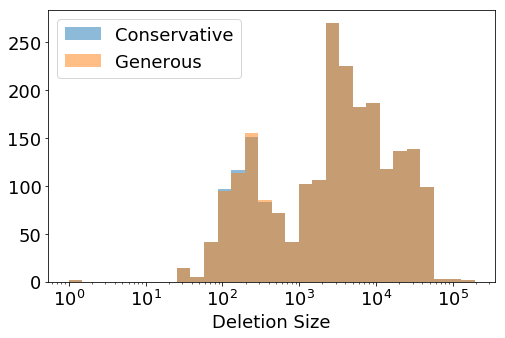

In [253]:
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(8, 5))
base = 1.5
max_length = max([x.opt_length for x in deletions])
min_length = min([x.length for x in deletions])
print(np.median([x.length for x in deletions]), min_length, max_length)

min_bin = math.floor(math.log(min_length, base))
max_bin = math.ceil(math.log(max_length, base))+1
plt.hist([x.length for x in deletions], 
         bins=[pow(base, i) for i in range(min_bin, max_bin)], alpha=0.5, label='Conservative')
plt.hist([x.opt_length for x in deletions], 
         bins=[pow(base, i) for i in range(min_bin, max_bin)], alpha=0.5, label='Generous')

plt.gca().set_xscale("log")
plt.xlabel('Deletion Size')
#plt.axvline(med_length, color='black', linestyle='--')
#plt.text(med_length-8000,1700,'median=%d'%med_length,rotation=90)
plt.legend()
plt.show()

0.0
2191


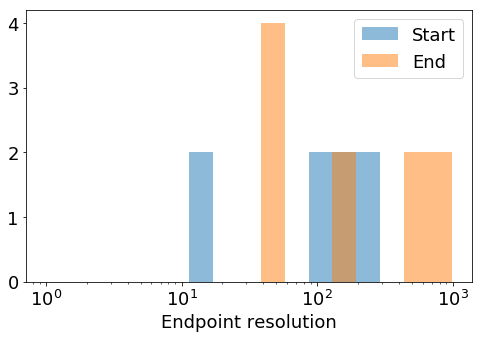

In [254]:
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(8, 5))
base = 1.5
max_length = max([x.start_pos - x.opt_start_pos for x in deletions] + [x.opt_end_pos - x.end_pos for x in deletions])
min_length = min([x.start_pos - x.opt_start_pos for x in deletions] + [x.opt_end_pos - x.end_pos for x in deletions])
print(np.median([x.start_pos - x.opt_start_pos for x in deletions] + [x.opt_end_pos - x.end_pos for x in deletions]))

print(len([x for x in deletions if x.opt_start_pos == x.start_pos or x.opt_end_pos == x.end_pos]))

min_bin = 0 if min_length == 0 else math.floor(math.log(min_length, base))
max_bin = math.ceil(math.log(max_length, base))+1
plt.hist([x.start_pos - x.opt_start_pos for x in deletions], 
         bins=[pow(base, i) for i in range(min_bin, max_bin)], alpha=0.5, label='Start')
plt.hist([x.opt_end_pos - x.end_pos for x in deletions], 
         bins=[pow(base, i) for i in range(min_bin, max_bin)], alpha=0.5, label='End')

plt.gca().set_xscale("log")
plt.xlabel('Endpoint resolution')
#plt.axvline(med_length, color='black', linestyle='--')
#plt.text(med_length-8000,1700,'median=%d'%med_length,rotation=90)
plt.legend()
plt.show()

In [255]:
dels_per_family = defaultdict(int)
mat_dels_per_family, pat_dels_per_family = defaultdict(int), defaultdict(int)
bases_per_family = defaultdict(int)
mat_bases_per_family, pat_bases_per_family = defaultdict(int), defaultdict(int)
for d in deletions:
    dels_per_family[d.family] += 1
    bases_per_family[d.family] += d.length
    
    if d.is_mat:
        mat_dels_per_family[d.family] += 1
        mat_bases_per_family[d.family] += d.length
    if d.is_pat:
        pat_dels_per_family[d.family] += 1
        pat_bases_per_family[d.family] += d.length
        

min 1 max 15


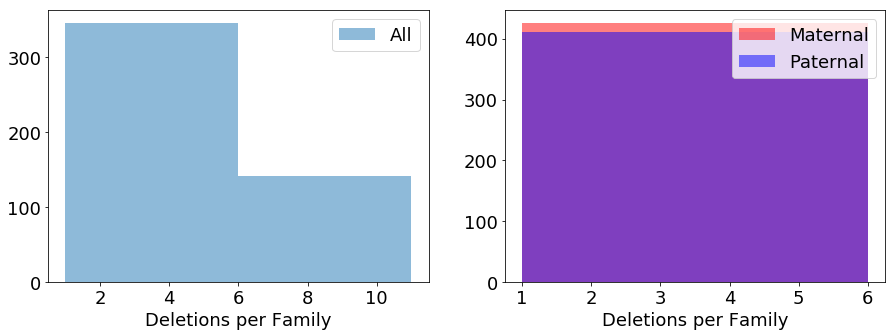

In [256]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(15, 5))

max_length = max(dels_per_family.values()) 
min_length = min(dels_per_family.values())

print('min', min_length, 'max', max_length)

mp_max_length = max(list(mat_dels_per_family.values()) + list(pat_dels_per_family.values()))
mp_min_length = min(list(mat_dels_per_family.values()) + list(pat_dels_per_family.values()))

plt.subplot(1, 2, 1)
plt.hist(dels_per_family.values(), alpha=0.5, bins=range(min_length, max_length, 5), label='All')

plt.legend()
plt.xlabel('Deletions per Family')

plt.subplot(1, 2, 2)
plt.hist(mat_dels_per_family.values(), alpha=0.5, bins=range(mp_min_length, mp_max_length, 5), label='Maternal', color='red')
plt.hist(pat_dels_per_family.values(), alpha=0.5, bins=range(mp_min_length, mp_max_length, 5), label='Paternal', color='blue')

plt.legend()
plt.xlabel('Deletions per Family')


plt.show()

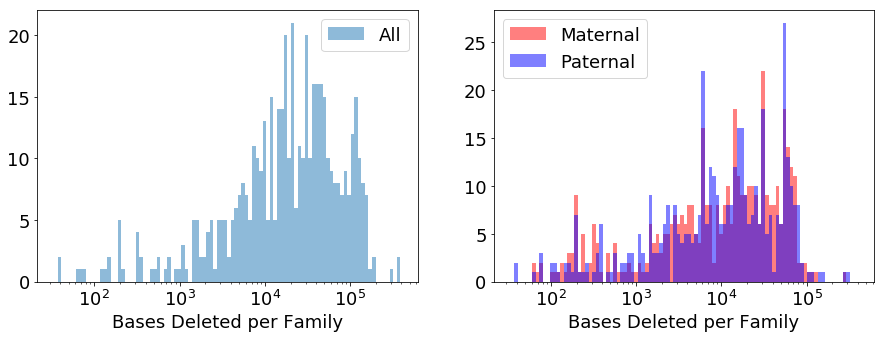

In [257]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(15, 5))
base = 1.1

max_length = max(bases_per_family.values()) 
min_length = min(bases_per_family.values()) 

min_bin = math.floor(math.log(min_length, base))-1
max_bin = math.ceil(math.log(max_length, base))+1

mp_max_length = max(list(mat_bases_per_family.values()) + list(pat_bases_per_family.values()))
mp_min_length = min(list(mat_bases_per_family.values()) + list(pat_bases_per_family.values()))

mp_min_bin = math.floor(math.log(min_length, base))-1
mp_max_bin = math.ceil(math.log(max_length, base))+1

plt.subplot(1, 2, 1)
plt.hist(bases_per_family.values(), alpha=0.5, 
         bins=[pow(base, i) for i in range(min_bin, max_bin)], label='All')

plt.gca().set_xscale("log")
plt.legend()
plt.xlabel('Bases Deleted per Family')

plt.subplot(1, 2, 2)
plt.hist(mat_bases_per_family.values(), alpha=0.5, 
         bins=[pow(base, i) for i in range(mp_min_bin, mp_max_bin)], label='Maternal', color='red')
plt.hist(pat_bases_per_family.values(), alpha=0.5, 
         bins=[pow(base, i) for i in range(mp_min_bin, mp_max_bin)], label='Paternal', color='blue')

plt.gca().set_xscale("log")
plt.legend()
plt.xlabel('Bases Deleted per Family')


plt.show()

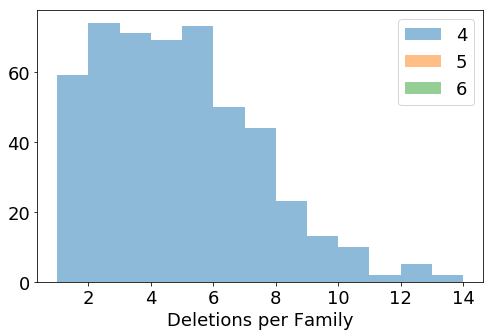

In [258]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(8, 5))

max_length = max(dels_per_family.values()) 
min_length = min(dels_per_family.values()) 

mp_max_length = max(list(mat_dels_per_family.values()) + list(pat_dels_per_family.values()))
mp_min_length = min(list(mat_dels_per_family.values()) + list(pat_dels_per_family.values()))

plt.hist([v for k, v in dels_per_family.items() if len(family_to_individuals[k])==4], alpha=0.5, bins=range(min_length, max_length), label='4')
plt.hist([v for k, v in dels_per_family.items() if len(family_to_individuals[k])==5], alpha=0.5, bins=range(min_length, max_length), label='5')
plt.hist([v for k, v in dels_per_family.items() if len(family_to_individuals[k])==6], alpha=0.5, bins=range(min_length, max_length), label='6')

plt.legend()
plt.xlabel('Deletions per Family')


plt.show()

3.0


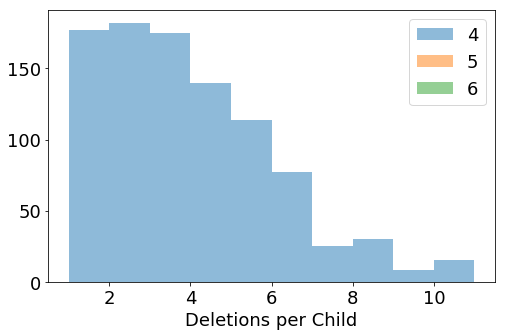

In [259]:
individual_to_family_size = dict()
for inds in family_to_individuals.values():
    for ind in inds:
        individual_to_family_size[ind] = len(inds)

child_to_num_dels = defaultdict(int)
for d in deletions:
    for child in d.trans:
        child_to_num_dels[child] += 1
        
plt.figure(figsize=(8, 5))

max_length = max(child_to_num_dels.values()) 
min_length = min(child_to_num_dels.values()) 

#plt.hist(child_to_num_dels.values(), alpha=0.5, bins=range(min_length, max_length))
plt.hist([v for k, v in child_to_num_dels.items() if individual_to_family_size[k]==4], alpha=0.5, bins=range(min_length, max_length), label='4')
plt.hist([v for k, v in child_to_num_dels.items() if individual_to_family_size[k]==5], alpha=0.5, bins=range(min_length, max_length), label='5')
plt.hist([v for k, v in child_to_num_dels.items() if individual_to_family_size[k]==6], alpha=0.5, bins=range(min_length, max_length), label='6')
plt.legend()
plt.xlabel('Deletions per Child')

print(np.median(list(child_to_num_dels.values())))
plt.show()

15454.5


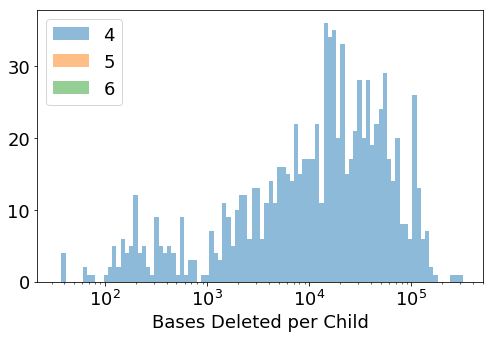

In [260]:
child_to_num_bases = defaultdict(int)
for d in deletions:
    for child in d.trans:
        child_to_num_bases[child] += d.length
        
plt.figure(figsize=(8, 5))

max_length = max(child_to_num_bases.values()) 
min_length = min(child_to_num_bases.values()) 

min_bin = math.floor(math.log(min_length, base))-1
max_bin = math.ceil(math.log(max_length, base))+1

#plt.hist(child_to_num_bases.values(), alpha=0.5, 
#         bins=[pow(base, i) for i in range(min_bin, max_bin)])
plt.hist([v for k, v in child_to_num_bases.items() if individual_to_family_size[k]==4], alpha=0.5, bins=[pow(base, i) for i in range(min_bin, max_bin)], label='4')
plt.hist([v for k, v in child_to_num_bases.items() if individual_to_family_size[k]==5], alpha=0.5, bins=[pow(base, i) for i in range(min_bin, max_bin)], label='5')
plt.hist([v for k, v in child_to_num_bases.items() if individual_to_family_size[k]==6], alpha=0.5, bins=[pow(base, i) for i in range(min_bin, max_bin)], label='6')
plt.legend()

plt.gca().set_xscale("log")
plt.xlabel('Bases Deleted per Child')



print(np.median(list(child_to_num_bases.values())))
plt.show()

15454.5


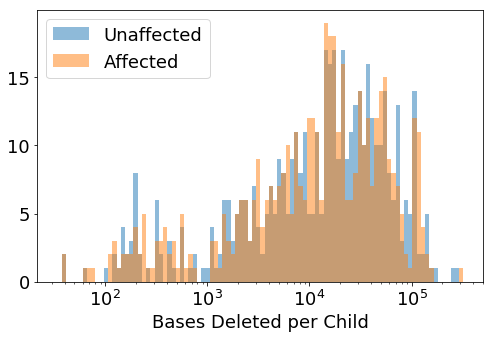

In [261]:
child_to_num_bases = defaultdict(int)
for d in deletions:
    for child in d.trans:
        child_to_num_bases[child] += d.length
        
plt.figure(figsize=(8, 5))

max_length = max(child_to_num_bases.values()) 
min_length = min(child_to_num_bases.values()) 

min_bin = math.floor(math.log(min_length, base))-1
max_bin = math.ceil(math.log(max_length, base))+1

#plt.hist(child_to_num_bases.values(), alpha=0.5, 
#         bins=[pow(base, i) for i in range(min_bin, max_bin)])
plt.hist([v for k, v in child_to_num_bases.items() if child_id_to_affected[k]=='1'], alpha=0.5, bins=[pow(base, i) for i in range(min_bin, max_bin)], label='Unaffected')
plt.hist([v for k, v in child_to_num_bases.items() if child_id_to_affected[k]=='2'], alpha=0.5, bins=[pow(base, i) for i in range(min_bin, max_bin)], label='Affected')
plt.legend()

plt.gca().set_xscale("log")
plt.xlabel('Bases Deleted per Child')



print(np.median(list(child_to_num_bases.values())))
plt.show()

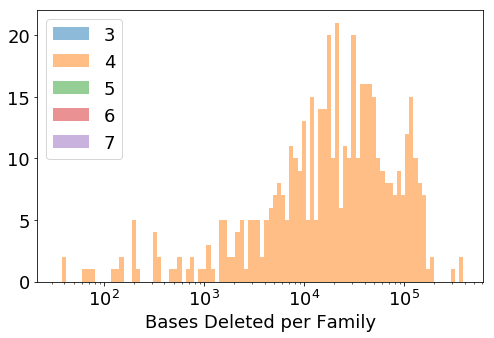

In [262]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(8, 5))
base = 1.1

max_length = max(bases_per_family.values()) 
min_length = min(bases_per_family.values()) 

min_bin = math.floor(math.log(min_length, base))-1
max_bin = math.ceil(math.log(max_length, base))+1

plt.hist([v for k, v in bases_per_family.items() if len(family_to_individuals[k])==3], alpha=0.5, bins=[pow(base, i) for i in range(min_bin, max_bin)], label='3')
plt.hist([v for k, v in bases_per_family.items() if len(family_to_individuals[k])==4], alpha=0.5, bins=[pow(base, i) for i in range(min_bin, max_bin)], label='4')
plt.hist([v for k, v in bases_per_family.items() if len(family_to_individuals[k])==5], alpha=0.5, bins=[pow(base, i) for i in range(min_bin, max_bin)], label='5')
plt.hist([v for k, v in bases_per_family.items() if len(family_to_individuals[k])==6], alpha=0.5, bins=[pow(base, i) for i in range(min_bin, max_bin)], label='6')
plt.hist([v for k, v in bases_per_family.items() if len(family_to_individuals[k])==7], alpha=0.5, bins=[pow(base, i) for i in range(min_bin, max_bin)], label='7')

plt.gca().set_xscale("log")
plt.legend()
plt.xlabel('Bases Deleted per Family')


plt.show()

In [263]:
#deletions = ihart_deletions + ssc_deletions
positions = sorted(set(sum([[(x.chrom, x.start_pos), (x.chrom, x.end_pos)] for x in deletions], [])), key=lambda x:(int(x[0]), x[1]))
individuals = sorted(set(sum([x.trans+x.notrans for x in deletions], [])))
pos_to_index = dict([(x, i) for i, x in enumerate(positions)])
ind_to_index = dict([(x, i) for i, x in enumerate(individuals)])

dm = np.zeros((len(ind_to_index), len(pos_to_index)), dtype=int)
for d in deletions:
    start_index, end_index = pos_to_index[(d.chrom, d.start_pos)], pos_to_index[(d.chrom, d.end_pos)]
    for ind in d.trans:
        dm[ind_to_index[ind], start_index:(end_index+1)] = 1

In [264]:
from scipy.stats import fisher_exact, chi2_contingency

affected_indices = [i for i, x in enumerate(individuals) if child_id_to_affected[x] == '2']
unaffected_indices = [i for i, x in enumerate(individuals) if child_id_to_affected[x] == '1']
contingency = np.zeros((len(positions), 2, 2), dtype=int)

contingency[:, 0, 0] = np.sum(dm[affected_indices, :]==1, axis=0)
contingency[:, 0, 1] = np.sum(dm[affected_indices, :]==0, axis=0)
contingency[:, 1, 0] = np.sum(dm[unaffected_indices, :]==1, axis=0)
contingency[:, 1, 1] = np.sum(dm[unaffected_indices, :]==0, axis=0)

num_tests = 0
p_values = np.ones((len(positions),))
for i in range(len(positions)):
    dc = contingency[i]

    if np.all(dc>10):
        p_values[i] = chi2_contingency(dc, correction=False)[1]
        num_tests += 1
    else:
        p_values[i] = fisher_exact(dc)[1]
        num_tests += 1
print(num_tests)

1322


In [265]:
chrom_lengths = {
	'1': 249250621,
	'2': 243199373,
	'3': 198022430,
	'4': 191154276,
	'5': 180915260,
	'6': 171115067,
	'7': 159138663,
	'8': 146364022,
	'9': 141213431,
	'10': 135534747,
	'11': 135006516,
	'12': 133851895,
	'13': 115169878,
	'14': 107349540,
	'15': 102531392,
	'16': 90354753,
	'17': 81195210,
	'18': 78077248,
	'19': 59128983,
	'20': 63025520,
	'21': 48129895,
	'22': 51304566,
	'X': 155270560,
	'Y': 59373566
}
chrom_start_points = {'1': 249250621}
for i in range(2, 23):
    chrom_start_points[str(i)] = chrom_start_points[str(i-1)] + chrom_lengths[str(i)]

xaxis = np.asarray([chrom_start_points[p[0]]+p[1] for p in positions])

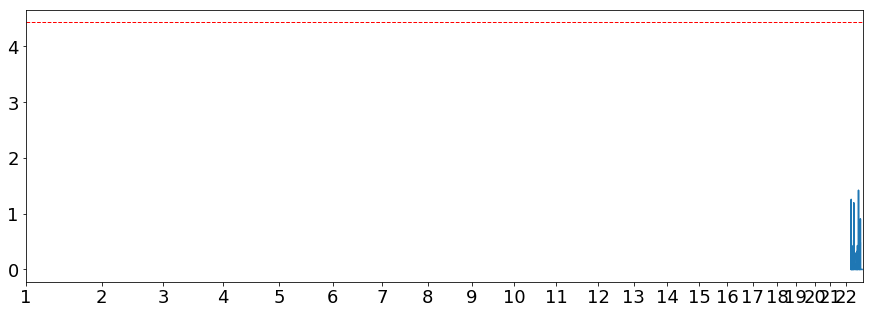

In [266]:
plt.figure(figsize=(15, 5))

plt.plot(xaxis, -np.log10(p_values))
plt.axhline(y=-np.log10(0.05/num_tests), linewidth=1, linestyle='--', color='r')
plt.xticks([chrom_start_points[str(i)] for i in range(1, 23)], [str(i) for i in range(1, 23)])

plt.show()

In [267]:
indices = np.argsort(p_values)[:20]
for ind in indices:
    print(p_values[ind], positions[ind])

0.038188550591 ('22', 39387284)
0.0387172503335 ('22', 39384707)
0.041482556845 ('22', 39387216)
0.0431407463461 ('22', 39387079)
0.0448047408212 ('22', 39386800)
0.0481455825353 ('22', 39386396)
0.0481455825353 ('22', 39384725)
0.0481455825353 ('22', 39384715)
0.0548501388146 ('22', 39384352)
0.0556521335582 ('22', 16050933)
0.0575927585291 ('22', 39386594)
0.0639693162129 ('22', 24273514)
0.0690954856923 ('22', 39382498)
0.0744624986627 ('22', 16050839)
0.0744624986627 ('22', 16050822)
0.0785552752127 ('22', 39387411)
0.0818311958429 ('22', 39384703)
0.0820024973746 ('22', 39387316)
0.0861137126541 ('22', 39372510)
0.0861137126541 ('22', 39377044)


In [268]:
Interval = namedtuple('Deletion', ['chrom', 'start_pos', 'end_pos', 'length'])

def check_overlap(d1, d2):
    if d1.chrom == d2.chrom:
        if d1.end_pos < d2.start_pos or d2.end_pos < d1.start_pos:
            overlap = 0
        elif d1.start_pos <= d2.start_pos and d1.end_pos >= d2.end_pos:
            overlap = d2.length
        elif d2.start_pos <= d1.start_pos and d2.end_pos >= d1.end_pos:
            overlap = d1.length
        elif d2.start_pos < d1.end_pos:
            overlap = d1.end_pos - d2.start_pos + 1
        elif d1.start_pos < d2.end_pos:
            overlap = d2.end_pos - d1.start_pos + 1

        if overlap/d1.length >= 0.5 and overlap/d2.length >= 0.5:
            return True
    return False

unique_deletions = dict()
for d in deletions:
    added = False
    for k, v in unique_deletions.items():
        if check_overlap(d, k):
            v.append(d)
            added = True
            break
    if not added:
        unique_deletions[Interval(d.chrom, d.start_pos, d.end_pos, d.length)] = [d]
            
        
print(len(unique_deletions))

287


In [269]:
print(len(deletions), len(unique_deletions))
intervals = sorted(unique_deletions.keys(), key=lambda x: (int(x.chrom), x.start_pos))

ud = np.zeros((len(individuals), len(intervals)))
for i, inter in enumerate(intervals):
    for d in unique_deletions[inter]:
        for x in d.trans:
            ud[ind_to_index[x], i] = 1

2193 287


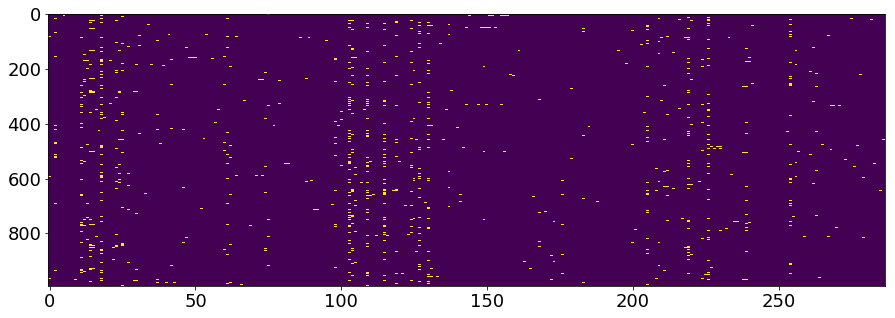

In [270]:
plt.figure(figsize=(15, 5))
plt.imshow(ud, aspect='auto')
plt.show()

In [271]:
from scipy.stats import fisher_exact

int_contingency = np.zeros((len(intervals), 2, 2), dtype=int)

int_contingency[:, 0, 0] = np.sum(ud[affected_indices, :]==1, axis=0)
int_contingency[:, 0, 1] = np.sum(ud[affected_indices, :]==0, axis=0)
int_contingency[:, 1, 0] = np.sum(ud[unaffected_indices, :]==1, axis=0)
int_contingency[:, 1, 1] = np.sum(ud[unaffected_indices, :]==0, axis=0)

num_tests = 0
p_values = np.ones((len(intervals),))
for i in range(len(intervals)):
    dc = int_contingency[i]

    if np.all(dc>10):
        p_values[i] = chi2_contingency(dc, correction=False)[1]
        num_tests += 1
    else:
        p_values[i] = fisher_exact(dc)[1]
        num_tests += 1
print(num_tests)

287


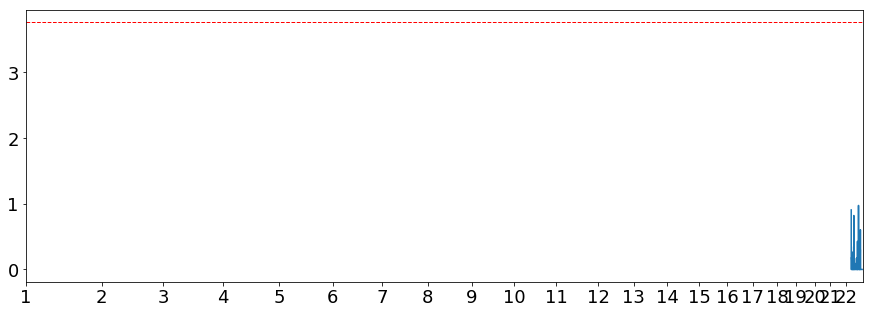

In [272]:
plt.figure(figsize=(15, 5))

xaxis = np.asarray([chrom_start_points[p.chrom]+p.start_pos for p in intervals])
plt.plot(xaxis, -np.log10(p_values))
plt.axhline(y=-np.log10(0.05/num_tests), linewidth=1, linestyle='--', color='r')
plt.xticks([chrom_start_points[str(i)] for i in range(1, 23)], [str(i) for i in range(1, 23)])

plt.show()

In [273]:
indices = np.argsort(p_values)[:5]
for ind in indices:
    print(p_values[ind], intervals[ind])

0.106212215254 Deletion(chrom='22', start_pos=39358038, end_pos=39388826, length=30789)
0.124243571313 Deletion(chrom='22', start_pos=16050116, end_pos=16051346, length=1231)
0.151132468539 Deletion(chrom='22', start_pos=24294904, end_pos=24299304, length=4401)
0.176473555661 Deletion(chrom='22', start_pos=25186985, end_pos=25187125, length=141)
0.228335231942 Deletion(chrom='22', start_pos=16050252, end_pos=16050839, length=588)


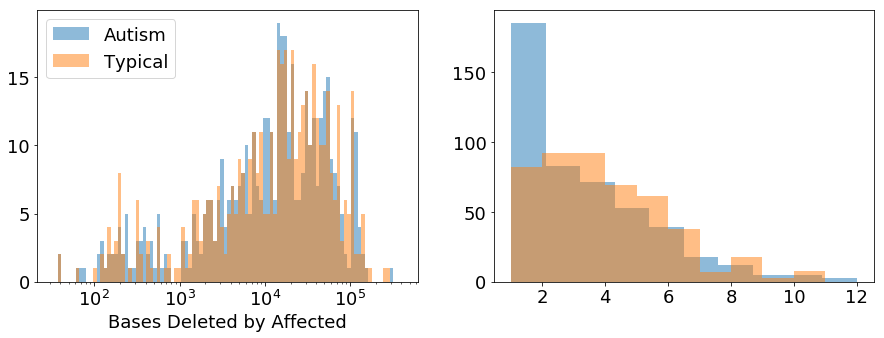

Ttest_indResult(statistic=-0.84344176535528825, pvalue=0.39919554911236343)
26763.7953586
28436.9191489
Ttest_indResult(statistic=-0.16860937912816631, pvalue=0.86614011230812005)
3.49789029536
3.52127659574


In [274]:
from scipy import stats

ind_to_bases_deleted = defaultdict(int)
ind_to_deletions = defaultdict(int)
for d in deletions:
    for x in d.trans:
        ind_to_bases_deleted[x] += d.length
        ind_to_deletions[x] += 1
        
plt.figure(figsize=(15, 5))
base = 1.1

max_length = max(bases_per_family.values()) 
min_length = min(bases_per_family.values()) 

min_bin = math.floor(math.log(min_length, base))-1
max_bin = math.ceil(math.log(max_length, base))+1

plt.subplot(1, 2, 1)
plt.hist([v for k, v in ind_to_bases_deleted.items() if child_id_to_affected[k] == '2'], alpha=0.5, bins=[pow(base, i) for i in range(min_bin, max_bin)], label='Autism')
plt.hist([v for k, v in ind_to_bases_deleted.items() if child_id_to_affected[k] == '1'], alpha=0.5, bins=[pow(base, i) for i in range(min_bin, max_bin)], label='Typical')

plt.gca().set_xscale("log")
plt.legend()
plt.xlabel('Bases Deleted by Affected')

plt.subplot(1, 2, 2)
plt.hist([v for k, v in ind_to_deletions.items() if child_id_to_affected[k] == '2'], alpha=0.5, label='Autism')
plt.hist([v for k, v in ind_to_deletions.items() if child_id_to_affected[k] == '1'], alpha=0.5, label='Typical')


plt.show()

print(stats.ttest_ind([np.log(v) for k, v in ind_to_bases_deleted.items() if child_id_to_affected[k] == '2'], 
                      [np.log(v) for k, v in ind_to_bases_deleted.items() if child_id_to_affected[k] == '1'], equal_var = False))
print(np.mean([v for k, v in ind_to_bases_deleted.items() if child_id_to_affected[k] == '2']))
print(np.mean([v for k, v in ind_to_bases_deleted.items() if child_id_to_affected[k] == '1']))

print(stats.ttest_ind([v for k, v in ind_to_deletions.items() if child_id_to_affected[k] == '2'], 
                      [v for k, v in ind_to_deletions.items() if child_id_to_affected[k] == '1'], equal_var = False))
print(np.mean([v for k, v in ind_to_deletions.items() if child_id_to_affected[k] == '2']))
print(np.mean([v for k, v in ind_to_deletions.items() if child_id_to_affected[k] == '1']))


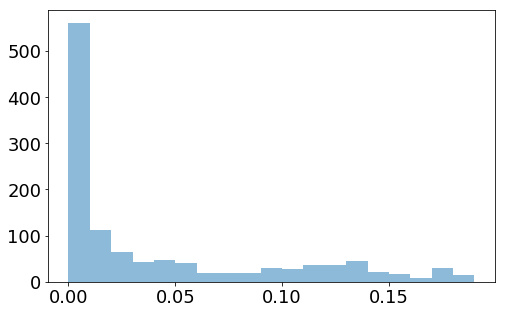

In [275]:
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(8, 5))
base = 1.3

s = np.sum(dm, axis=0)/len(ind_to_index)
plt.hist(s, alpha=0.5, bins=[x*0.01 for x in range(20)])
#plt.yscale('log')
plt.show()

In [276]:
from scipy.stats import chi2_contingency
#common_positions = set([positions[i] for i in np.where(s>0.2)[0]])
#print('Common positions', len(common_positions))

#print(len(deletions))
d = deletions
#d = [d for d in deletions if (d.chrom, d.start_pos) not in common_positions and (d.chrom, d.end_pos) not in common_positions]
#print(len(d))
print('Maternal vs Paternal')
c = [[sum([len(x.trans) for x in d if x.is_mat]),
     sum([len(x.notrans) for x in d if x.is_mat])],
    [sum([len(x.trans) for x in d if x.is_pat]),
    sum([len(x.notrans) for x in d if x.is_pat])]]
#print(c)
print(np.sum(c, axis=1))
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Autistic vs Typical')
c = [[sum([len([y for y in x.trans if child_id_to_affected[y] == '2']) for x in d]),
     sum([len([y for y in x.notrans if child_id_to_affected[y] == '2']) for x in d])],
    [sum([len([y for y in x.trans if child_id_to_affected[y] != '2']) for x in d]),
    sum([len([y for y in x.notrans if child_id_to_affected[y] != '2']) for x in d])]]
print(np.sum(c, axis=1))
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Female vs Male')
c = [[sum([len([y for y in x.trans if child_id_to_sex[y] == '2']) for x in d]),
     sum([len([y for y in x.notrans if child_id_to_sex[y] == '2']) for x in d])],
    [sum([len([y for y in x.trans if child_id_to_sex[y] == '1']) for x in d]),
    sum([len([y for y in x.notrans if child_id_to_sex[y] == '1']) for x in d])]]
#print(c)
print(np.sum(c, axis=1))
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Females: Autistic vs Typical')
c = [[sum([len([y for y in x.trans if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '2']) for x in d]),
     sum([len([y for y in x.notrans if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '2']) for x in d])],
    [sum([len([y for y in x.trans if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '2']) for x in d]),
    sum([len([y for y in x.notrans if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '2']) for x in d])]]
#print(c)
print(np.sum(c, axis=1))
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Males: Autistic vs Typical')
c = [[sum([len([y for y in x.trans if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '1']) for x in d]),
     sum([len([y for y in x.notrans if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '1']) for x in d])],
    [sum([len([y for y in x.trans if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '1']) for x in d]),
    sum([len([y for y in x.notrans if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '1']) for x in d])]]
#print(c)
print(np.sum(c, axis=1))
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

Maternal vs Paternal
[2198 2188]
ratios 0.752 0.759
pvalue 0.609207851412

Autistic vs Typical
[2193 2193]
ratios 0.756 0.755
pvalue 0.916076827681

Female vs Male
[1303 2969]
ratios 0.757 0.753
pvalue 0.742322457618

Females: Autistic vs Typical
[ 205 1098]
ratios 0.756 0.758
pvalue 0.959797793509

Males: Autistic vs Typical
[1959 1010]
ratios 0.754 0.750
pvalue 0.766538161955



# Compare iHART and SSC

In [202]:
print('iHART families', len(set([x.family for x in ihart_deletions])))
print('SSC families', len(set([x.family for x in ssc_deletions])))

iHART families 302
SSC families 302


In [277]:
import cycler

prop_cycle = plt.rcParams['axes.prop_cycle']
matplotlib.rcParams['axes.prop_cycle'] = cycler.cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
colors = prop_cycle.by_key()['color']

ssc_deletions = deletions
ssc_dels_per_family = dels_per_family
ssc_bases_per_family = bases_per_family
ssc_s = s

#ihart_deletions = deletions
#ihart_dels_per_family = dels_per_family
#ihart_bases_per_family = bases_per_family
#ihart_s = s


Medians: iHART 4753.0 iHART-4 5542.0 SSC 3297.0


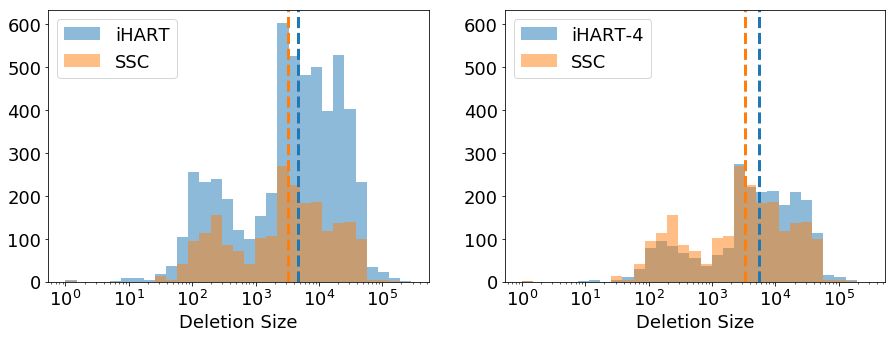

In [278]:
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(15, 5))
base = 1.5
max_length = max([x.length for x in ihart_deletions]+[x.length for x in ssc_deletions])
min_length = min([x.length for x in ihart_deletions]+[x.length for x in ssc_deletions])
ihart_med_length = np.median([x.length for x in ihart_deletions])
ssc_med_length = np.median([x.length for x in ssc_deletions])
ihart4_med_length = np.median([x.length for x in ihart_deletions if len(x.trans+x.notrans)==2])

print('Medians:', 'iHART', ihart_med_length, 'iHART-4', ihart4_med_length, 'SSC', ssc_med_length)

min_bin = math.floor(math.log(min_length, base))
max_bin = math.ceil(math.log(max_length, base))+1

ax1 = plt.subplot(1, 2, 1)
plt.hist([x.length for x in ihart_deletions], 
         bins=[pow(base, i) for i in range(min_bin, max_bin)], alpha=0.5, label='iHART')
plt.hist([x.opt_length for x in ssc_deletions], 
         bins=[pow(base, i) for i in range(min_bin, max_bin)], alpha=0.5, label='SSC')

plt.gca().set_xscale("log")
plt.xlabel('Deletion Size')

plt.axvline(ihart_med_length, linestyle='--', linewidth=3, color=colors[0])
#plt.text(ihart_med_length-8000,200,'median=%d'%ihart_med_length,rotation=90)

plt.axvline(ssc_med_length, linestyle='--', linewidth=3,color=colors[1])
#plt.text(ssc_med_length,200,'median=%d'%ssc_med_length,rotation=90)
plt.legend()

plt.subplot(1, 2, 2, sharey=ax1)
plt.hist([x.length for x in ihart_deletions if len(x.trans+x.notrans)==2], 
         bins=[pow(base, i) for i in range(min_bin, max_bin)], alpha=0.5, label='iHART-4')
plt.hist([x.opt_length for x in ssc_deletions], 
         bins=[pow(base, i) for i in range(min_bin, max_bin)], alpha=0.5, label='SSC')

plt.gca().set_xscale("log")
plt.xlabel('Deletion Size')

plt.axvline(ihart4_med_length, linestyle='--', linewidth=3, color=colors[0])
#plt.text(ihart4_med_length-8000,200,'median=%d'%ihart4_med_length,rotation=90)

plt.axvline(ssc_med_length, linestyle='--', linewidth=3,color=colors[1])
#plt.text(ssc_med_length,200,'median=%d'%ssc_med_length,rotation=90)

plt.legend()
plt.show()

Median: 4336.0


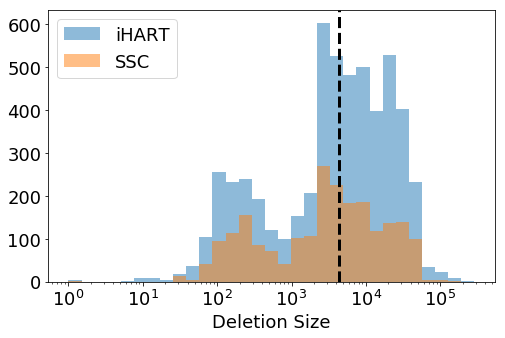

In [279]:
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(8, 5))
base = 1.5
max_length = max([x.length for x in ihart_deletions]+[x.length for x in ssc_deletions])
min_length = min([x.length for x in ihart_deletions]+[x.length for x in ssc_deletions])
med_length = np.median([x.length for x in ihart_deletions]+[x.length for x in ssc_deletions])

print('Median:', med_length)

min_bin = math.floor(math.log(min_length, base))
max_bin = math.ceil(math.log(max_length, base))+1

plt.hist([x.length for x in ihart_deletions], 
         bins=[pow(base, i) for i in range(min_bin, max_bin)], alpha=0.5, label='iHART')
plt.hist([x.opt_length for x in ssc_deletions], 
         bins=[pow(base, i) for i in range(min_bin, max_bin)], alpha=0.5, label='SSC')

plt.gca().set_xscale("log")
plt.xlabel('Deletion Size')

plt.axvline(med_length, linestyle='--', linewidth=3, color='black')
#plt.text(ihart_med_length-8000,200,'median=%d'%ihart_med_length,rotation=90)

plt.legend()

plt.show()

Median: 0.0


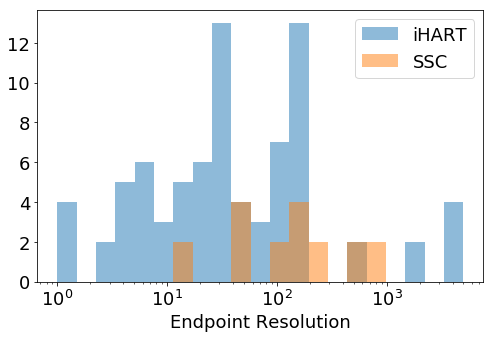

In [280]:
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(8, 5))
base = 1.5
ihart_intervals = [x.start_pos-x.opt_start_pos for x in ihart_deletions]+[x.opt_end_pos-x.end_pos for x in ihart_deletions]
ssc_intervals = [x.start_pos-x.opt_start_pos for x in ssc_deletions]+[x.opt_end_pos-x.end_pos for x in ssc_deletions]
max_length = max(ihart_intervals+ssc_intervals)
min_length = min(ihart_intervals+ssc_intervals)
med_length = np.median(ihart_intervals+ssc_intervals)

print('Median:', med_length)

min_bin = 0 if min_length == 0 else math.floor(math.log(min_length, base))
max_bin = math.ceil(math.log(max_length, base))+1

plt.hist(ihart_intervals, 
         bins=[pow(base, i) for i in range(min_bin, max_bin)], alpha=0.5, label='iHART')
plt.hist(ssc_intervals, 
         bins=[pow(base, i) for i in range(min_bin, max_bin)], alpha=0.5, label='SSC')

plt.gca().set_xscale("log")
plt.xlabel('Endpoint Resolution')

plt.axvline(med_length, linestyle='--', linewidth=3, color='black')
#plt.text(ihart_med_length-8000,200,'median=%d'%ihart_med_length,rotation=90)

plt.legend()

plt.show()

Medians: iHART 6.0 SSC 4.0


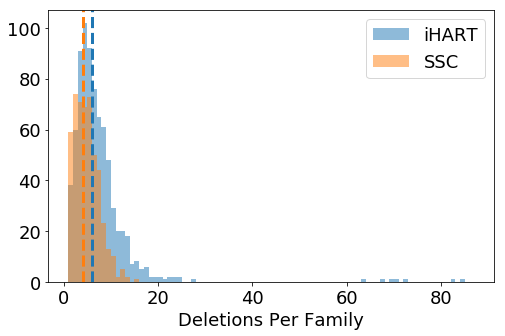

In [281]:
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(8, 5))
base = 1.1
max_length = max(list(ihart_dels_per_family.values()) + list(ssc_dels_per_family.values()))
min_length = min(list(ihart_dels_per_family.values()) + list(ssc_dels_per_family.values()))
ihart_med_length = np.median(list(ihart_dels_per_family.values()))
ssc_med_length = np.median(list(ssc_dels_per_family.values()))

print('Medians:', 'iHART', ihart_med_length, 'SSC', ssc_med_length)

plt.hist(ihart_dels_per_family.values(), 
         bins= range(min_length, max_length), alpha=0.5, label='iHART')
plt.hist(ssc_dels_per_family.values(), 
         bins=range(min_length, max_length), alpha=0.5, label='SSC')

plt.axvline(ihart_med_length, linestyle='--', linewidth=3, color=colors[0])
#plt.text(ihart_med_length,4,'median=%d'%ihart_med_length,rotation=90)

plt.axvline(ssc_med_length, linestyle='--', linewidth=3,color=colors[1])
#plt.text(ssc_med_length,4,'median=%d'%ssc_med_length,rotation=90)

plt.xlabel('Deletions Per Family')
plt.legend()

plt.show()

Median: 5.0


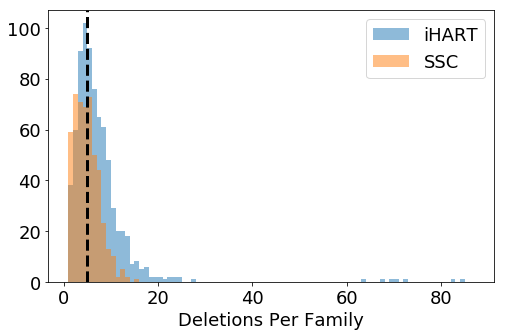

In [282]:
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(8, 5))
base = 1.1
max_length = max(list(ihart_dels_per_family.values()) + list(ssc_dels_per_family.values()))
min_length = min(list(ihart_dels_per_family.values()) + list(ssc_dels_per_family.values()))
med_length = np.median(list(ihart_dels_per_family.values())+list(ssc_dels_per_family.values()))

print('Median:', med_length)

plt.hist(ihart_dels_per_family.values(), 
         bins= range(min_length, max_length), alpha=0.5, label='iHART')
plt.hist(ssc_dels_per_family.values(), 
         bins=range(min_length, max_length), alpha=0.5, label='SSC')

plt.axvline(med_length, linestyle='--', linewidth=3, color='black')
#plt.text(ihart_med_length,4,'median=%d'%ihart_med_length,rotation=90)

plt.xlabel('Deletions Per Family')
plt.legend()

plt.show()

Median: 32455.5


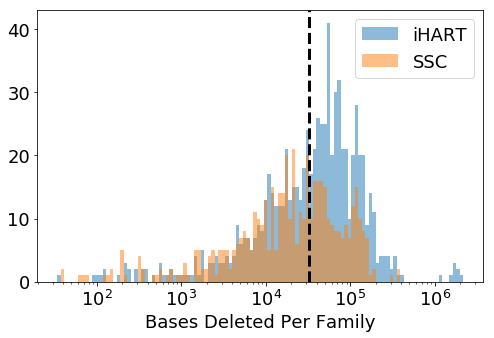

In [283]:
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(8, 5))
base = 1.1
max_length = max(list(ihart_bases_per_family.values()) + list(ssc_bases_per_family.values()))
min_length = min(list(ihart_bases_per_family.values()) + list(ssc_bases_per_family.values()))
med_length = np.median(list(ihart_bases_per_family.values())+list(ssc_bases_per_family.values()))

print('Median:', med_length)

min_bin = math.floor(math.log(min_length, base))
max_bin = math.ceil(math.log(max_length, base))+1

plt.hist(ihart_bases_per_family.values(), 
         bins=[pow(base, i) for i in range(min_bin, max_bin)], alpha=0.5, label='iHART')
plt.hist(ssc_bases_per_family.values(), 
         bins=[pow(base, i) for i in range(min_bin, max_bin)], alpha=0.5, label='SSC')

plt.gca().set_xscale("log")
plt.xlabel('Bases Deleted Per Family')

plt.axvline(med_length, linestyle='--', linewidth=3, color='black')
#plt.text(ihart_med_length,10,'median=%d'%ihart_med_length,rotation=90)

plt.legend()

plt.show()

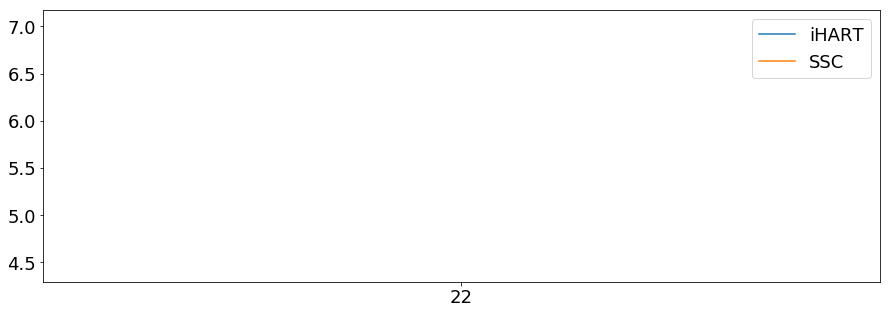

In [284]:
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(15, 5))

ihart_chromdels, ssc_chromdels = [], []
for chrom in chroms:
    ihart_chromdels.append(len([x for x in ihart_deletions if x.chrom == chrom])/len(ihart_bases_per_family))
    ssc_chromdels.append(len([x for x in ssc_deletions if x.chrom == chrom])/len(ssc_bases_per_family))

plt.plot(chroms, ihart_chromdels, label='iHART')
plt.plot(chroms, ssc_chromdels, label='SSC')

plt.xticks(chroms)
plt.legend()

plt.show()

In [285]:
from scipy.stats import chi2_contingency

print('---------- iHART ----------')
d = ihart_deletions

print('Maternal vs Paternal')
c = [[sum([len(x.trans) for x in d if x.is_mat]),
     sum([len(x.notrans) for x in d if x.is_mat])],
    [sum([len(x.trans) for x in d if x.is_pat]),
    sum([len(x.notrans) for x in d if x.is_pat])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Autistic vs Typical')
c = [[sum([len([y for y in x.trans if child_id_to_affected[y] == '2']) for x in d]),
     sum([len([y for y in x.notrans if child_id_to_affected[y] == '2']) for x in d])],
    [sum([len([y for y in x.trans if child_id_to_affected[y] != '2']) for x in d]),
    sum([len([y for y in x.notrans if child_id_to_affected[y] != '2']) for x in d])]]
print(np.sum(c, axis=1))
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Female vs Male')
c = [[sum([len([y for y in x.trans if child_id_to_sex[y] == '2']) for x in d]),
     sum([len([y for y in x.notrans if child_id_to_sex[y] == '2']) for x in d])],
    [sum([len([y for y in x.trans if child_id_to_sex[y] == '1']) for x in d]),
    sum([len([y for y in x.notrans if child_id_to_sex[y] == '1']) for x in d])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Females: Autistic vs Typical')
c = [[sum([len([y for y in x.trans if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '2']) for x in d]),
     sum([len([y for y in x.notrans if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '2']) for x in d])],
    [sum([len([y for y in x.trans if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '2']) for x in d]),
    sum([len([y for y in x.notrans if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '2']) for x in d])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Males: Autistic vs Typical')
c = [[sum([len([y for y in x.trans if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '1']) for x in d]),
     sum([len([y for y in x.notrans if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '1']) for x in d])],
    [sum([len([y for y in x.trans if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '1']) for x in d]),
    sum([len([y for y in x.notrans if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '1']) for x in d])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Maternal Male: Autistic vs Typical')
c = [[sum([len([y for y in x.trans if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '1']) for x in d if x.is_mat]),
     sum([len([y for y in x.notrans if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '1']) for x in d if x.is_mat])],
    [sum([len([y for y in x.trans if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '1']) for x in d if x.is_mat]),
    sum([len([y for y in x.notrans if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '1']) for x in d if x.is_mat])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Paternal Male: Autistic vs Typical')
c = [[sum([len([y for y in x.trans if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '1']) for x in d if x.is_pat]),
     sum([len([y for y in x.notrans if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '1']) for x in d if x.is_pat])],
    [sum([len([y for y in x.trans if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '1']) for x in d if x.is_pat]),
    sum([len([y for y in x.notrans if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '1']) for x in d if x.is_pat])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('---------- SSC ----------')
d = ssc_deletions

print('Maternal vs Paternal')
c = [[sum([len(x.trans) for x in d if x.is_mat]),
     sum([len(x.notrans) for x in d if x.is_mat])],
    [sum([len(x.trans) for x in d if x.is_pat]),
    sum([len(x.notrans) for x in d if x.is_pat])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Autistic vs Typical')
c = [[sum([len([y for y in x.trans if child_id_to_affected[y] == '2']) for x in d]),
     sum([len([y for y in x.notrans if child_id_to_affected[y] == '2']) for x in d])],
    [sum([len([y for y in x.trans if child_id_to_affected[y] == '1']) for x in d]),
    sum([len([y for y in x.notrans if child_id_to_affected[y] == '1']) for x in d])]]
print(np.sum(c, axis=1))
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Female vs Male')
c = [[sum([len([y for y in x.trans if child_id_to_sex[y] == '2']) for x in d]),
     sum([len([y for y in x.notrans if child_id_to_sex[y] == '2']) for x in d])],
    [sum([len([y for y in x.trans if child_id_to_sex[y] == '1']) for x in d]),
    sum([len([y for y in x.notrans if child_id_to_sex[y] == '1']) for x in d])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Females: Autistic vs Typical')
c = [[sum([len([y for y in x.trans if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '2']) for x in d]),
     sum([len([y for y in x.notrans if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '2']) for x in d])],
    [sum([len([y for y in x.trans if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '2']) for x in d]),
    sum([len([y for y in x.notrans if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '2']) for x in d])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Males: Autistic vs Typical')
c = [[sum([len([y for y in x.trans if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '1']) for x in d]),
     sum([len([y for y in x.notrans if child_id_to_affected[y] == '2' and child_id_to_sex[y] == '1']) for x in d])],
    [sum([len([y for y in x.trans if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '1']) for x in d]),
    sum([len([y for y in x.notrans if child_id_to_affected[y] != '2' and child_id_to_sex[y] == '1']) for x in d])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Maternal: Autistic vs Typical')
c = [[sum([len([y for y in x.trans if child_id_to_affected[y] == '2']) for x in d if x.is_mat]),
     sum([len([y for y in x.notrans if child_id_to_affected[y] == '2']) for x in d if x.is_mat])],
    [sum([len([y for y in x.trans if child_id_to_affected[y] != '2']) for x in d if x.is_mat]),
    sum([len([y for y in x.notrans if child_id_to_affected[y] != '2']) for x in d if x.is_mat])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Paternal: Autistic vs Typical')
c = [[sum([len([y for y in x.trans if child_id_to_affected[y] == '2']) for x in d if x.is_pat]),
     sum([len([y for y in x.notrans if child_id_to_affected[y] == '2']) for x in d if x.is_pat])],
    [sum([len([y for y in x.trans if child_id_to_affected[y] != '2']) for x in d if x.is_pat]),
    sum([len([y for y in x.notrans if child_id_to_affected[y] != '2']) for x in d if x.is_pat])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()




---------- iHART ----------
Maternal vs Paternal
ratios 0.684 0.665
pvalue 0.0159866681049

Autistic vs Typical
[11405  2833]
ratios 0.687 0.623
pvalue 7.01236220197e-11

Female vs Male
ratios 0.600 0.709
pvalue 7.5894064683e-38

Females: Autistic vs Typical
ratios 0.607 0.587
pvalue 0.192245008501

Males: Autistic vs Typical
ratios 0.715 0.666
pvalue 0.000267263548836

Maternal Male: Autistic vs Typical
ratios 0.721 0.656
pvalue 0.000894636067821

Paternal Male: Autistic vs Typical
ratios 0.710 0.675
pvalue 0.0660491598004

---------- SSC ----------
Maternal vs Paternal
ratios 0.752 0.759
pvalue 0.609207851412

Autistic vs Typical
[2193 2193]
ratios 0.756 0.755
pvalue 0.916076827681

Female vs Male
ratios 0.757 0.753
pvalue 0.742322457618

Females: Autistic vs Typical
ratios 0.756 0.758
pvalue 0.959797793509

Males: Autistic vs Typical
ratios 0.754 0.750
pvalue 0.766538161955

Maternal: Autistic vs Typical
ratios 0.733 0.771
pvalue 0.0428491750863

Paternal: Autistic vs Typical
ratios

# Transmission rate per child

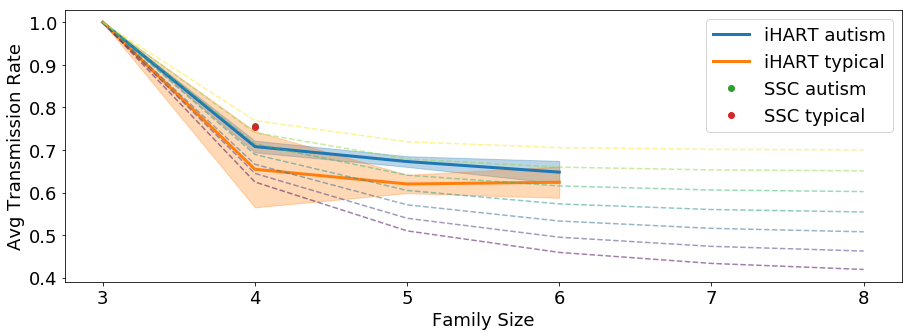

In [286]:
from scipy.stats import binom
import cycler

plt.figure(figsize=(15, 5))

ps = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]


#trs = [sum([len(x.trans) for x in ihart3_deletions])/sum([len(x.trans)+len(x.notrans) for x in ihart3_deletions]),
#       sum([len(x.trans) for x in ihart4_deletions])/sum([len(x.trans)+len(x.notrans) for x in ihart4_deletions]),
#      sum([len(x.trans) for x in ihart5_deletions])/sum([len(x.trans)+len(x.notrans) for x in ihart5_deletions]),
#      sum([len(x.trans) for x in ihart6_deletions])/sum([len(x.trans)+len(x.notrans) for x in ihart6_deletions])]


#ns = [sum([len(x.trans)+len(x.notrans) for x in ihart3_deletions]),
#      sum([len(x.trans)+len(x.notrans) for x in ihart4_deletions]),
#      sum([len(x.trans)+len(x.notrans) for x in ihart5_deletions]),
#      sum([len(x.trans)+len(x.notrans) for x in ihart6_deletions])]

aff = '2'
aff_trs = [sum([len([y for y in x.trans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==1])/sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==1]),
       sum([len([y for y in x.trans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==2])/sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==2]),
      sum([len([y for y in x.trans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==3])/sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==3]),
      sum([len([y for y in x.trans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==4])/sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==4])]
aff_ns = [sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==1]),
      sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==2]),
      sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==3]),
      sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==4])]

aff = '1'
typ_trs = [sum([len([y for y in x.trans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==1])/sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==1]),
       sum([len([y for y in x.trans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==2])/sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==2]),
      sum([len([y for y in x.trans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==3])/sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==3]),
      sum([len([y for y in x.trans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==4])/sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==4])]
typ_ns = [sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==1]),
      sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==2]),
      sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==3]),
      sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_deletions if len(x.trans+x.notrans)==4])]

matplotlib.rcParams['axes.prop_cycle'] = cycler.cycler('color', plt.cm.viridis(np.linspace(0, 1, len(ps))))

plt.plot(range(1, 5), aff_trs, linewidth=3, label='iHART autism', color=colors[0])
plt.fill_between(range(1, 5), [p-2*math.sqrt(p*(1-p)/n) for (p, n) in zip(aff_trs, aff_ns)], [p+2*math.sqrt(p*(1-p)/n) for (p, n) in zip(aff_trs, aff_ns)], alpha=0.3, color=colors[0])
plt.plot(range(1, 5), typ_trs, linewidth=3, label='iHART typical', color=colors[1])
plt.fill_between(range(1, 5), [p-2*math.sqrt(p*(1-p)/n) for (p, n) in zip(typ_trs, typ_ns)], [p+2*math.sqrt(p*(1-p)/n) for (p, n) in zip(typ_trs, typ_ns)], alpha=0.3, color=colors[1])

ssc_tr = sum([len(x.trans) for x in ssc_deletions])/sum([len(x.trans)+len(x.notrans) for x in ssc_deletions])
aff = '2'
ssc_aff_tr = sum([len([y for y in x.trans if child_id_to_affected[y] == aff]) for x in ssc_deletions])/sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ssc_deletions])
aff = '1'
ssc_typ_tr = sum([len([y for y in x.trans if child_id_to_affected[y] == aff]) for x in ssc_deletions])/sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ssc_deletions])

plt.plot([2], [ssc_aff_tr], 'o', label='SSC autism', color=colors[2])
plt.plot([2], [ssc_typ_tr], 'o', label='SSC typical', color=colors[3])


xs = range(1, 7)
for p in ps:
    ts, ns = np.zeros((len(xs,))), np.zeros((len(xs,)))
    for j, x in enumerate(xs):
        t = sum([i*binom.pmf(i, x, p) for i in range(1, x+1)])
        n = sum([(x-i)*binom.pmf(i, x, p) for i in range(1, x+1)])
        ts[j] = t
        ns[j] = n
    ys = ts/(ts+ns)
    plt.plot(xs, ys, linestyle='--', alpha=0.5)
    
plt.legend()
plt.xticks(range(1, 7), range(3, 9))
plt.ylabel('Avg Transmission Rate')
plt.xlabel('Family Size')

plt.show()
matplotlib.rcParams['axes.prop_cycle'] = cycler.cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])


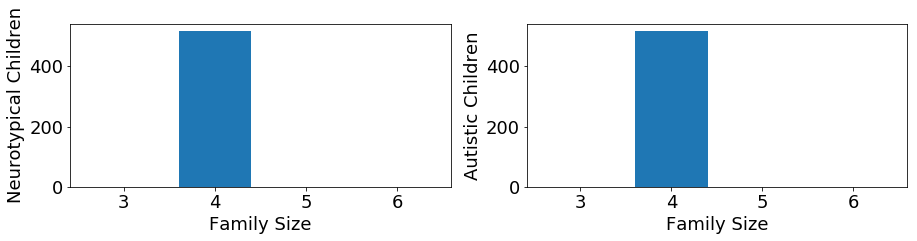

In [287]:
familysize = range(3, 7)
numaut = [sum([len([x for x in inds[2:] if child_id_to_affected[x] == '2']) for k, inds in family_to_individuals.items() if len(inds) == 3]),
         sum([len([x for x in inds[2:] if child_id_to_affected[x] == '2']) for k, inds in family_to_individuals.items() if len(inds) == 4]),
         sum([len([x for x in inds[2:] if child_id_to_affected[x] == '2']) for k, inds in family_to_individuals.items() if len(inds) == 5]),
         sum([len([x for x in inds[2:] if child_id_to_affected[x] == '2']) for k, inds in family_to_individuals.items() if len(inds) == 6])]
numtyp = [sum([len([x for x in inds[2:] if child_id_to_affected[x] == '1']) for k, inds in family_to_individuals.items() if len(inds) == 3]),
         sum([len([x for x in inds[2:] if child_id_to_affected[x] == '1']) for k, inds in family_to_individuals.items() if len(inds) == 4]),
         sum([len([x for x in inds[2:] if child_id_to_affected[x] == '1']) for k, inds in family_to_individuals.items() if len(inds) == 5]),
         sum([len([x for x in inds[2:] if child_id_to_affected[x] == '1']) for k, inds in family_to_individuals.items() if len(inds) == 6])]

plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.bar(familysize, numtyp)
plt.ylabel('Neurotypical Children')
plt.xlabel('Family Size')

plt.subplot(1, 2, 2)
plt.bar(familysize, numaut)
plt.ylabel('Autistic Children')
plt.xlabel('Family Size')
plt.show()

0.300829875519 0.276209677419


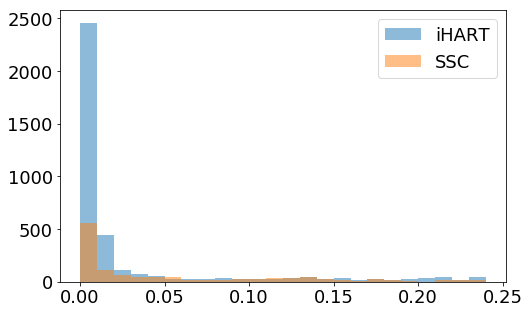

In [288]:
matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(8, 5))
base = 1.3
print(np.max(ihart_s), np.max(ssc_s))
a = plt.hist(ihart_s, alpha=0.5, bins=[x*0.01 for x in range(25)], label='iHART')
b = plt.hist(ssc_s, alpha=0.5, bins=[x*0.01 for x in range(25)], label='SSC')
plt.legend()

#plt.yscale('log')
plt.show()

# DiGeorge

In [289]:
chrom = '22'
start_pos, end_pos = 17900000, 25900000
#chrom = '15'
#start_pos, end_pos = 15800000, 33600000
#chrom = 16
#start_pos, end_pos = 28100000, 34600000
#chrom = 7,
#start_pos, end_pos = 72200000, 77500000
ihart_digeorge_dels = [x for x in ihart_deletions if x.chrom == chrom and x.start_pos <= start_pos and x.end_pos >= end_pos] \
+ [x for x in ihart_deletions if x.chrom == chrom and x.start_pos >= start_pos and x.end_pos <= end_pos]
print('iHART', len(ihart_digeorge_dels))

ihart_digeorge_dels = ihart_digeorge_dels + [x for x in ihart_deletions if x.chrom == chrom and x.start_pos <= start_pos and x.end_pos >= start_pos]\
+ [x for x in ihart_deletions if x.chrom == chrom and x.start_pos <= end_pos and x.end_pos >= end_pos]
print('iHART', len(ihart_digeorge_dels))

print('iHART', 'Maternal', len([x for x in ihart_digeorge_dels if x.is_mat]), 'Paternal', len([x for x in ihart_digeorge_dels if x.is_pat]))

ssc_digeorge_dels = [x for x in ssc_deletions if x.chrom == chrom and x.start_pos <= start_pos and x.end_pos >= end_pos] \
+ [x for x in ssc_deletions if x.chrom == chrom and x.start_pos >= start_pos and x.end_pos <= end_pos]
print('SSC', len(ssc_digeorge_dels))

ssc_digeorge_dels = ssc_digeorge_dels + [x for x in ssc_deletions if x.chrom == chrom and x.start_pos <= start_pos and x.end_pos >= start_pos]\
+ [x for x in ssc_deletions if x.chrom == chrom and x.start_pos <= end_pos and x.end_pos >= end_pos]
print('SSC', len(ssc_digeorge_dels))

print('SSC', 'Maternal', len([x for x in ssc_digeorge_dels if x.is_mat]), 'Paternal', len([x for x in ssc_digeorge_dels if x.is_pat]))


#d = ssc_digeorge_dels

print('iHART')
d = ihart_digeorge_dels
print('Maternal vs Paternal')
c = [[sum([len(x.trans) for x in d if x.is_mat]),
     sum([len(x.notrans) for x in d if x.is_mat])],
    [sum([len(x.trans) for x in d if x.is_pat]),
    sum([len(x.notrans) for x in d if x.is_pat])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Autistic vs Typical')
print(c)
c = [[sum([len([y for y in x.trans if child_id_to_affected[y] == '2']) for x in d]),
     sum([len([y for y in x.notrans if child_id_to_affected[y] == '2']) for x in d])],
    [sum([len([y for y in x.trans if child_id_to_affected[y] != '2']) for x in d]),
    sum([len([y for y in x.notrans if child_id_to_affected[y] != '2']) for x in d])]]
print(np.sum(c, axis=1))
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('SSC')
d = ssc_digeorge_dels
print('Maternal vs Paternal')
c = [[sum([len(x.trans) for x in d if x.is_mat]),
     sum([len(x.notrans) for x in d if x.is_mat])],
    [sum([len(x.trans) for x in d if x.is_pat]),
    sum([len(x.notrans) for x in d if x.is_pat])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Autistic vs Typical')
print(c)
c = [[sum([len([y for y in x.trans if child_id_to_affected[y] == '2']) for x in d]),
     sum([len([y for y in x.notrans if child_id_to_affected[y] == '2']) for x in d])],
    [sum([len([y for y in x.trans if child_id_to_affected[y] != '2']) for x in d]),
    sum([len([y for y in x.notrans if child_id_to_affected[y] != '2']) for x in d])]]
print(np.sum(c, axis=1))
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Both')
d = ihart_digeorge_dels+ssc_digeorge_dels
print('Maternal vs Paternal')
c = [[sum([len(x.trans) for x in d if x.is_mat]),
     sum([len(x.notrans) for x in d if x.is_mat])],
    [sum([len(x.trans) for x in d if x.is_pat]),
    sum([len(x.notrans) for x in d if x.is_pat])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Autistic vs Typical')
print(c)
c = [[sum([len([y for y in x.trans if child_id_to_affected[y] == '2']) for x in d]),
     sum([len([y for y in x.notrans if child_id_to_affected[y] == '2']) for x in d])],
    [sum([len([y for y in x.trans if child_id_to_affected[y] != '2']) for x in d]),
    sum([len([y for y in x.notrans if child_id_to_affected[y] != '2']) for x in d])]]
print(np.sum(c, axis=1))
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('iHART-6')
d = [x for x in ihart_digeorge_dels if len(x.trans+x.notrans)==4]
print('Maternal vs Paternal')
c = [[sum([len(x.trans) for x in d if x.is_mat]),
     sum([len(x.notrans) for x in d if x.is_mat])],
    [sum([len(x.trans) for x in d if x.is_pat]),
    sum([len(x.notrans) for x in d if x.is_pat])]]
#print(c)
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()

print('Autistic vs Typical')
print(c)
c = [[sum([len([y for y in x.trans if child_id_to_affected[y] == '2']) for x in d]),
     sum([len([y for y in x.notrans if child_id_to_affected[y] == '2']) for x in d])],
    [sum([len([y for y in x.trans if child_id_to_affected[y] != '2']) for x in d]),
    sum([len([y for y in x.notrans if child_id_to_affected[y] != '2']) for x in d])]]
print(np.sum(c, axis=1))
print('ratios', '%0.3f' % (c[0][0]/sum(c[0])), '%0.3f' % (c[1][0]/sum(c[1])))
print('pvalue', chi2_contingency(c, correction=False)[1])
print()


iHART 2855
iHART 2874
iHART Maternal 1447 Paternal 1427
SSC 1123
SSC 1126
SSC Maternal 568 Paternal 558
iHART
Maternal vs Paternal
ratios 0.661 0.633
pvalue 0.0107663730789

Autistic vs Typical
[[2508, 1286], [2398, 1390]]
[6077 1505]
ratios 0.659 0.600
pvalue 1.9802412599e-05

SSC
Maternal vs Paternal
ratios 0.727 0.735
pvalue 0.682166827879

Autistic vs Typical
[[826, 310], [820, 296]]
[1126 1126]
ratios 0.740 0.722
pvalue 0.341957358028

Both
Maternal vs Paternal
ratios 0.676 0.656
pvalue 0.0348395545705

Autistic vs Typical
[[3334, 1596], [3218, 1686]]
[7203 2631]
ratios 0.671 0.652
pvalue 0.0744206867775

iHART-6
Maternal vs Paternal
ratios 0.607 0.623
pvalue 0.575958222889

Autistic vs Typical
[[364, 236], [319, 193]]
[739 373]
ratios 0.632 0.579
pvalue 0.0874037090334



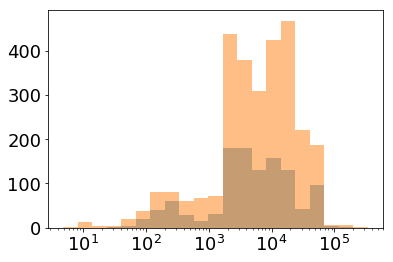

In [290]:
base = 1.7
ssc_len = [min(end_pos, x.end_pos)-max(start_pos, x.start_pos) for x in ssc_digeorge_dels]
ihart_len = [min(end_pos, x.end_pos)-max(start_pos, x.start_pos) for x in ihart_digeorge_dels]

max_length = max(ihart_len+ssc_len)
min_length = min(ihart_len+ssc_len)

min_bin = math.floor(math.log(min_length, base))
max_bin = math.ceil(math.log(max_length, base))+1

plt.hist(ssc_len, alpha=0.5, bins=[pow(base, i) for i in range(min_bin, max_bin)])
plt.hist(ihart_len, alpha=0.5, bins=[pow(base, i) for i in range(min_bin, max_bin)])
plt.gca().set_xscale("log")
plt.show()

In [291]:
import random
# prune back large families
small_fams = dict([(k, {random.choice([x for x in inds[2:] if child_id_to_affected[x] == '2']), 
                       random.choice([x for x in inds[2:] if child_id_to_affected[x] == '1'])}) for k, inds in family_to_individuals.items() if \
                   len([x for x in inds[2:] if child_id_to_affected[x] == '2'])>0 and len([x for x in inds[2:] if child_id_to_affected[x] == '1'])>0])

#small_fams = dict([(k, set(random.sample([x for x in inds[2:]], 2))) for k, inds in family_to_individuals.items() if len(inds[2:])>1])

print(len(ihart_digeorge_dels))
small_deletions = [x for x in ihart_digeorge_dels if x.family in small_fams and len([y for y in x.trans if y in small_fams[x.family]])>0]
print(len(ihart_digeorge_dels))
    

2874
2874


In [292]:
print([Counter(len(x.trans+x.notrans) for x in ihart_digeorge_dels)])

[Counter({3: 1324, 2: 1226, 4: 278, 1: 46})]


[nan, nan, 0.599437148217636, 0.579088471849866] [0, 66, 1066, 373]


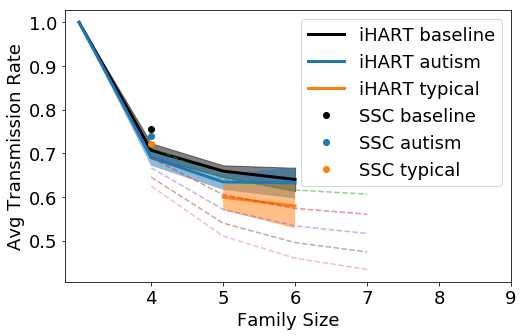

In [293]:
from scipy.stats import binom

plt.figure(figsize=(8, 5))

aff = '2'
aff_trs = [sum([len([y for y in x.trans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==1])/sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==1]),
       sum([len([y for y in x.trans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==2])/sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==2]),
      sum([len([y for y in x.trans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==3])/sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==3]),
      sum([len([y for y in x.trans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==4])/sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==4])]
aff_ns = [sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==1]),
      sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==2]),
      sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==3]),
      sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==4])]

aff = '1'
typ_trs = [np.nan,#sum([len([y for y in x.trans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==1])/sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==1]),
      np.nan,#sum([len([y for y in x.trans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==2])/sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==2]),
      sum([len([y for y in x.trans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==3])/sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==3]),
      sum([len([y for y in x.trans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==4])/sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==4])]
typ_ns = [sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==1]),
      sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==2]),
      sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==3]),
      sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==4])]

all_trs = [sum([len(x.trans) for x in ihart_deletions if len(x.trans+x.notrans)==1])/sum([len(x.trans+x.notrans) for x in ihart_deletions if len(x.trans+x.notrans)==1]),
       sum([len(x.trans) for x in ihart_deletions if len(x.trans+x.notrans)==2])/sum([len(x.trans+x.notrans) for x in ihart_deletions if len(x.trans+x.notrans)==2]),
      sum([len(x.trans) for x in ihart_deletions if len(x.trans+x.notrans)==3])/sum([len(x.trans+x.notrans) for x in ihart_deletions if len(x.trans+x.notrans)==3]),
      sum([len(x.trans) for x in ihart_deletions if len(x.trans+x.notrans)==4])/sum([len(x.trans+x.notrans) for x in ihart_deletions if len(x.trans+x.notrans)==4])]
all_ns = [sum([len(x.trans) for x in ihart_deletions if len(x.trans+x.notrans)==1]),
      sum([len(x.trans) for x in ihart_deletions if len(x.trans+x.notrans)==2]),
      sum([len(x.trans) for x in ihart_deletions if len(x.trans+x.notrans)==3]),
      sum([len(x.trans) for x in ihart_deletions if len(x.trans+x.notrans)==4])]

print(typ_trs, typ_ns)

plt.plot(range(1, 5), all_trs, linewidth=3, label='iHART baseline', color='black')
plt.fill_between(range(1, 5), [p-(2*math.sqrt(p*(1-p)/n)) for (p, n) in zip(all_trs, all_ns)], [p+(2*math.sqrt(p*(1-p)/n)) for (p, n) in zip(all_trs, all_ns)], alpha=0.5, color='black')
plt.plot(range(1, 5), aff_trs, linewidth=3, label='iHART autism')
plt.fill_between(range(1, 5), [p-(2*math.sqrt(p*(1-p)/n)) for (p, n) in zip(aff_trs, aff_ns)], [p+(2*math.sqrt(p*(1-p)/n)) for (p, n) in zip(aff_trs, aff_ns)], alpha=0.5)
plt.plot(range(1, 5), typ_trs, linewidth=3, label='iHART typical')
plt.fill_between(range(1, 5), [np.nan if n==0 else p-(2*math.sqrt(p*(1-p)/n)) for (p, n) in zip(typ_trs, typ_ns)], [np.nan if n==0 else p+(2*math.sqrt(p*(1-p)/n)) for (p, n) in zip(typ_trs, typ_ns)], alpha=0.5)

ssc_tr = sum([len(x.trans) for x in ssc_deletions])/sum([len(x.trans)+len(x.notrans) for x in ssc_deletions])
aff = '2'
ssc_aff_tr = sum([len([y for y in x.trans if child_id_to_affected[y] == aff]) for x in ssc_digeorge_dels])/sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ssc_digeorge_dels])
aff = '1'
ssc_typ_tr = sum([len([y for y in x.trans if child_id_to_affected[y] == aff]) for x in ssc_digeorge_dels])/sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == aff]) for x in ssc_digeorge_dels])

plt.plot([2], [ssc_tr], 'o', label='SSC baseline', color='black')
plt.plot([2], [ssc_aff_tr], 'o', label='SSC autism', color=colors[0])
plt.plot([2], [ssc_typ_tr], 'o', label='SSC typical', color=colors[1])

p = 0.4
x = 3

xs = range(2, 6)
for p in [0.4, 0.45, 0.5, 0.55, 0.6]:
    ys = []
    for x in xs:
        t = sum([(x-i)*binom.pmf(i, x, p) for i in range(x)])
        n = sum([i*binom.pmf(i, x, p) for i in range(x)])
        ys.append(t/(t+n))
    plt.plot(xs, ys, linestyle='--', alpha=0.5)
    
plt.legend()
plt.xticks(range(2, 8), range(4, 10))
plt.ylabel('Avg Transmission Rate')
plt.xlabel('Family Size')

plt.show()

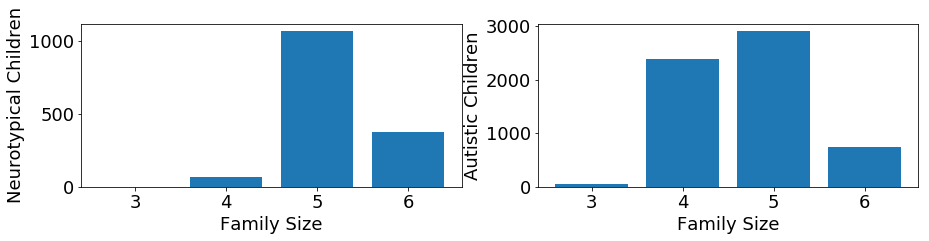

In [294]:
familysize = range(3, 7)
numaut = [sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == '2']) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==1]),
         sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == '2']) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==2]),
         sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == '2']) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==3]),
          sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == '2']) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==4])]
numtyp = [sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == '1']) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==1]),
         sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == '1']) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==2]),
         sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == '1']) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==3]),
          sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == '1']) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==4])]
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.bar(familysize, numtyp)
plt.ylabel('Neurotypical Children')
plt.xlabel('Family Size')

plt.subplot(1, 2, 2)
plt.bar(familysize, numaut)
plt.ylabel('Autistic Children')
plt.xlabel('Family Size')
plt.show()

In [295]:
familysize = range(3, 7)
numaut = [sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == '2']) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==1]),
         sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == '2']) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==2]),
         sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == '2']) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==3]),
          sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == '2']) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==4])]
numtyp = [sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == '1']) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==1]),
         sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == '1']) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==2]),
         sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == '1']) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==3]),
          sum([len([y for y in x.trans+x.notrans if child_id_to_affected[y] == '1']) for x in ihart_digeorge_dels if len(x.trans+x.notrans)==4])]
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.bar(familysize, [x+y for numtyp)
plt.ylabel('Neurotypical Children')
plt.xlabel('Family Size')

plt.subplot(1, 2, 2)
plt.bar(familysize, numaut)
plt.ylabel('Autistic Children')
plt.xlabel('Family Size')
plt.show()

SyntaxError: invalid syntax (<ipython-input-295-f3113661eec6>, line 12)

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


[1.         0.51282051 0.35056968 0.26955086 0.2210247 ]
[0.05 0.1  0.15 0.2  0.25]
[0.         0.095      0.277875   0.541975   0.88109531]


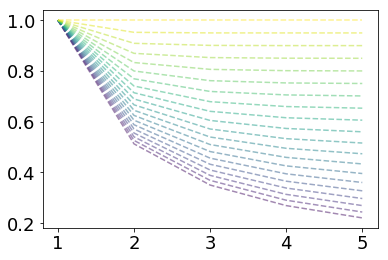

In [256]:
import cycler

ps = np.arange(0, 1.05, 0.05)
n = len(ps)
color = plt.cm.viridis(np.linspace(0, 1,n))
matplotlib.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

xs = range(1, 6)
for p in ps:
    ts, ns = np.zeros((len(xs,))), np.zeros((len(xs,)))
    for j, x in enumerate(xs):
        t = sum([i*binom.pmf(i, x, p) for i in range(1, x+1)])
        n = sum([(x-i)*binom.pmf(i, x, p) for i in range(1, x+1)])
        ts[j] = t
        ns[j] = n
    ys = ts/(ts+ns)

    plt.plot(xs, ys, linestyle='--', alpha=0.5)
    
    if p == 0.05:
        print(ys)
        print(ts)
        print(ns)
                   
plt.show()

matplotlib.rcParams['axes.prop_cycle'] = cycler.cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
                                                       
                                                       

In [121]:
import json

def switch_int64_to_int(x):
    for key in ['start_pos', 'end_pos', 'length', 'opt_start_pos', 'opt_end_pos', 'opt_length']:
        x[key] = int(x[key])
    return x

In [257]:

    
with open('../final_calls/filtered_iHART_miss_deletions.json', 'w+') as f:
    json.dump([switch_int64_to_int(x._asdict()) for x in ihart_deletions], f)
    
with open('../final_calls/filtered_SSC_miss_deletions.json', 'w+') as f:
    json.dump([switch_int64_to_int(x._asdict()) for x in ssc_deletions], f)

In [245]:

with open('../final_calls/filtered_test_deletions_ihart.json', 'w+') as f:
    json.dump([switch_int64_to_int(x._asdict()) for x in deletions], f)